---
title: "time lags practice"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: false
    code-summary: "Show the code"
---

Download <a href="lag_zip.zip" download>this zip</a> file before you start.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
import concurrent.futures
from datetime import datetime, timedelta
from scipy.signal import savgol_filter
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import datetime as dt
import matplotlib.ticker as ticker

# %matplotlib widget

The dataset we will work with has two columns:
1. `tree` - dendrometer data of a Jerusalem pine tree
1. `solar_elevation` - solar elevation at the site of the tree. As the sun rises the elevation increases and it sets as the elevation decreses. When elevation is negative then the sun is below the horizon.
  
The samplerate of the data 30min per row.

In [2]:
df = pd.read_csv('dendrometer.csv', index_col='time', parse_dates=True)
df

,tree,solar_elevation
time,,
2018-07-27 00:15:00,14.539567,-38.908466
2018-07-27 00:45:00,14.540535,-37.459337
2018-07-27 01:15:00,14.547314,-35.097718
2018-07-27 01:45:00,14.548283,-31.935865
2018-07-27 02:15:00,14.549250,-28.097681
...,...,...
2018-08-05 21:45:00,14.666420,-33.782927
2018-08-05 22:15:00,14.665451,-37.139744
2018-08-05 22:45:00,14.666420,-39.685352


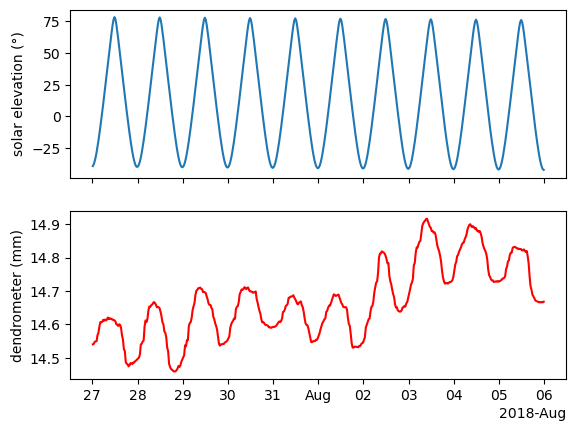

In [3]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(df['solar_elevation'])
ax[1].plot(df['tree'], c='r')

ax[0].set_ylabel('solar elevation (°)')
ax[1].set_ylabel('dendrometer (mm)')

locator = mdates.AutoDateLocator(minticks=7, maxticks=11)
formatter = mdates.ConciseDateFormatter(locator)
ax[1].xaxis.set_major_locator(locator)
ax[1].xaxis.set_major_formatter(formatter)

The tree contracts as water is leaving the trunk for transpiration. This usually happens during the day. Then the tree expands back at night when there is no transpiration. This is a slow process and there is some lag between the atmospheric conditions and the tree movement. We will quantify this lag.  
The first thing we will do is multiply the dendrometer data by -1 so it will move in the same direction as the sun elevation. This is just to make things more intuitive when applying cross correlation.

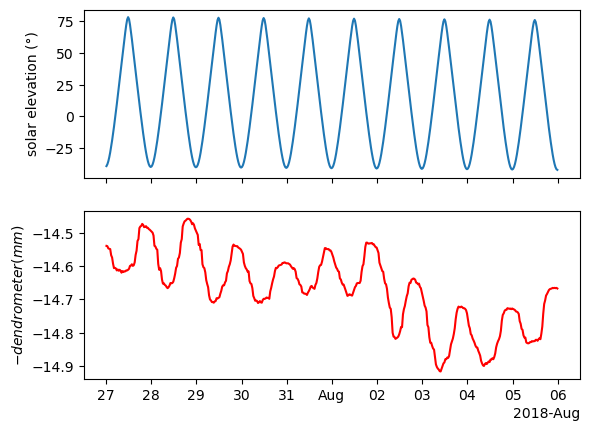

In [4]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(df['solar_elevation'])
ax[1].plot(df['tree']*-1, c='r')

ax[0].set_ylabel('solar elevation (°)')
ax[1].set_ylabel('$- dendrometer (mm)$')

locator = mdates.AutoDateLocator(minticks=7, maxticks=11)
formatter = mdates.ConciseDateFormatter(locator)
ax[1].xaxis.set_major_locator(locator)
ax[1].xaxis.set_major_formatter(formatter)

The dendrometer gives us the tree's circumference, but in this case we care more about the rate of change - is the tree expanding or contracting? how fast is it moving?  
We can answer these questions by computing the derivative of the dendrometer. A simple way to get a derivative from a time series is to compute the differences, as we learned before using the function `.diff()`. Another thing worth mentioning is that the original time series is not stationary, as we learned, differencing can aid in making it stationary.

In [5]:
df['tree_diff'] = df['tree'].diff()

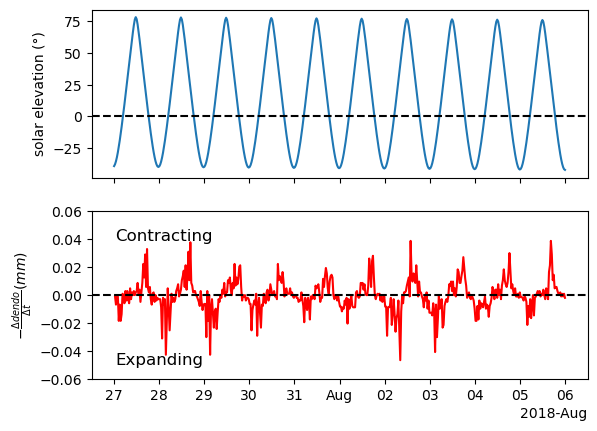

In [6]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(df['solar_elevation'])
ax[1].plot(-1*df['tree_diff'], c='r')

ax[0].set_ylabel('solar elevation (°)')
ax[1].set_ylabel(r'$-\frac{\Delta dendo}{\Delta t} (mm)$')

ax[0].axhline(0, c='black', ls='--')
ax[1].axhline(0, c='black', ls='--')

ax[1].text(df.index[1], 0.037, s='Contracting', ha='left', va='bottom', fontsize=12)
ax[1].text(df.index[1], -0.052, s='Expanding', ha='left', va='bottom', fontsize=12)
ax[1].set_ylim(-0.06,0.06)


locator = mdates.AutoDateLocator(minticks=7, maxticks=11)
formatter = mdates.ConciseDateFormatter(locator)
ax[1].xaxis.set_major_locator(locator)
ax[1].xaxis.set_major_formatter(formatter)

Now the time series is stationary but the results are a bit noisy. That is because there is some noise in the original signal that are more apparent after computing the differences. If we want a smoother derivative, we need to apply smoothing to the sata before. A practical solution is using the `scipy.signal.savgol_filter()` which has a derivative argument. By default, `deriv=0` so we don't get the derivative. But we can change it to whatever derivative order we want. We want the first derivative so we will use `deriv=1`. That way we get both smoothing and derivative using one function.

In [7]:
df['tree_der'] = savgol_filter(df['tree'], 24, 3, deriv=1)*-1

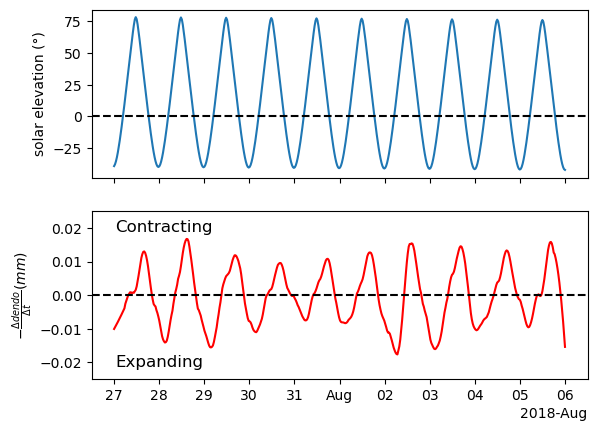

In [8]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(df['solar_elevation'])
ax[1].plot(df['tree_der'], c='r')

ax[0].set_ylabel('solar elevation (°)')
ax[1].set_ylabel(r'$-\frac{\Delta dendo}{\Delta t} (mm)$')

ax[0].axhline(0, c='black', ls='--')
ax[1].axhline(0, c='black', ls='--')

ax[1].text(df.index[1], 0.018, s='Contracting', ha='left', va='bottom', fontsize=12)
ax[1].text(df.index[1], -0.022, s='Expanding', ha='left', va='bottom', fontsize=12)
ax[1].set_ylim(-0.025,0.025)

locator = mdates.AutoDateLocator(minticks=7, maxticks=11)
formatter = mdates.ConciseDateFormatter(locator)
ax[1].xaxis.set_major_locator(locator)
ax[1].xaxis.set_major_formatter(formatter)


Now the signal is nice and smooth.  
The next thing we want to do is apply standardization as the values of the two time series are very different.

In [9]:
# creating a new standardized df
df_z = (df - df.mean())/df.std()

Now that we applied standardization we can plot them on the same ax.

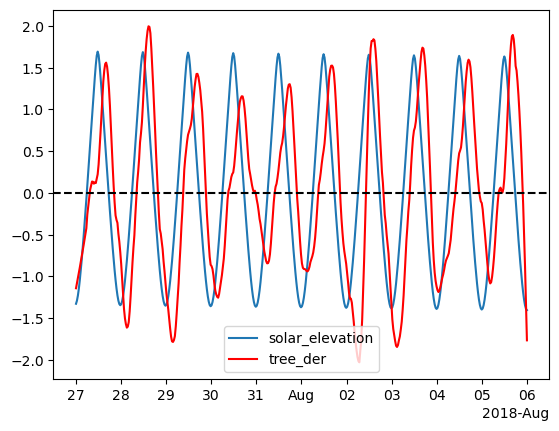

In [10]:
fig, ax = plt.subplots()

ax.plot(df_z['solar_elevation'], label='solar_elevation')
ax.plot(df_z['tree_der'], c='r', label='tree_der')
ax.axhline(0, c='black', ls='--')
ax.legend()

locator = mdates.AutoDateLocator(minticks=7, maxticks=11)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)


Now that the data is all processed we can work on finding the lag. lets apply cross correlation.

In [11]:
series1 = df_z['solar_elevation']
series2 = df_z['tree_der']

correlation = signal.correlate(series1, series2, mode='full', method='fft')
lags = signal.correlation_lags(len(series1), len(series2))
correlation /= (len(series1))

result_series = pd.Series(correlation, index=lags)

[Text(0.5, 0, 'Lag'), Text(0, 0.5, 'Correlation')]

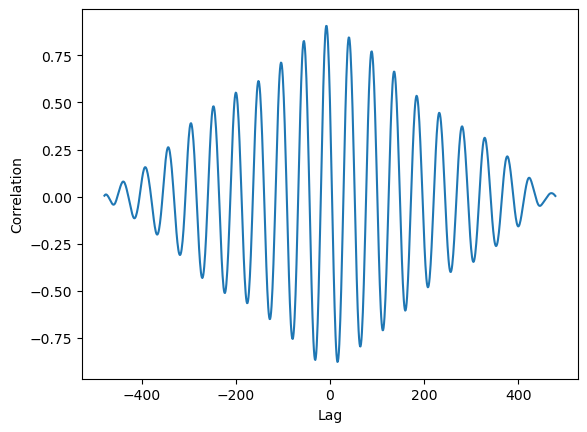

In [12]:
fig, ax = plt.subplots()

ax.plot(result_series)
ax.set(xlabel='Lag', ylabel='Correlation')

We know that the tree is lagging (not the opposite) and we know that the lag cant be more than 24hrs (48 points in our case). So lets limit the plot to the relevant range.

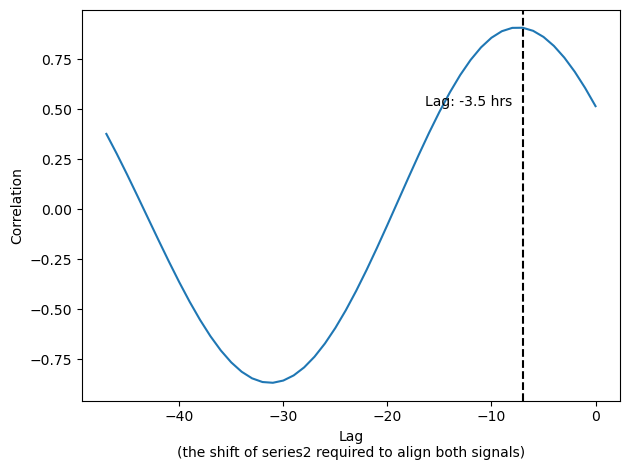

In [13]:
filtered_series = result_series[(result_series.index > -48) & (result_series.index <= 0)]

fig, ax = plt.subplots()

ax.plot(filtered_series)
# ax.axvline(filtered_series.idxmax(), c='black', ls='--')


max_index = filtered_series.idxmax()
ax.axvline(max_index, c='black', ls='--')

max_value = filtered_series[max_index]
ax.text(max_index-1, 0.5, f'Lag: {max_index/2} hrs', ha='right', va='bottom')

ax.set(xlabel='Lag\n(the shift of series2 required to align both signals)', ylabel='Correlation')
plt.tight_layout()


Note that we got a lag, we can shift the data and inspect it.

In [14]:
# Shift column B back by 3.5 hours
df_z['tree_der_shifted'] = df_z['tree_der'].shift(int(max_index))

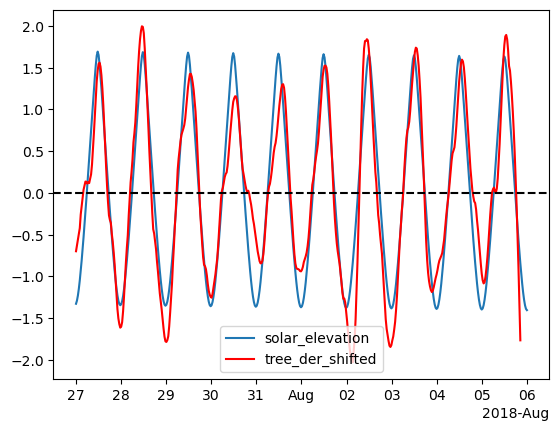

In [15]:
fig, ax = plt.subplots()

ax.plot(df_z['solar_elevation'], label='solar_elevation')
ax.plot(df_z['tree_der_shifted'], c='r', label='tree_der_shifted')
ax.axhline(0, c='black', ls='--')
ax.legend()
# ax.set_xlim(pd.Timestamp('2018-07-30'), pd.Timestamp('2018-08-01'))

locator = mdates.AutoDateLocator(minticks=7, maxticks=11)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

Any thoughts of the results? Is it perfect? What is the resolution of our shift?  
We can increase the resolution to get a more accurate shift by upsampling the data.

In [16]:
df_z_resampled = df_z.resample('T').interpolate()

In [17]:
series1 = df_z_resampled['solar_elevation']
series2 = df_z_resampled['tree_der']

correlation = signal.correlate(series1, series2, mode='full', method='fft')
lags = signal.correlation_lags(len(series1), len(series2))
correlation /= (len(series1))

result_series = pd.Series(correlation, index=lags)

[Text(0.5, 0, 'Lag'), Text(0, 0.5, 'Correlation')]

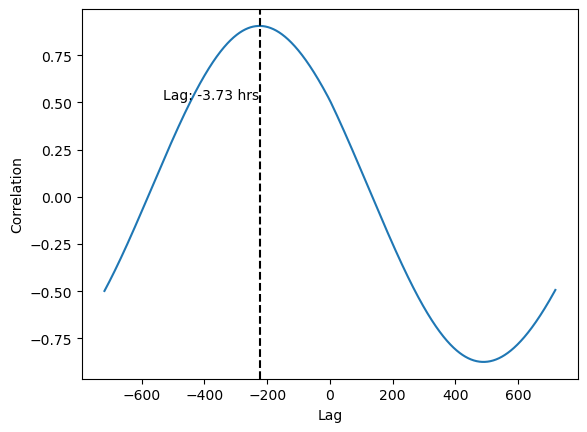

In [18]:
filtered_series = result_series[(result_series.index > -60*12) & (result_series.index < 60*12)]

fig, ax = plt.subplots()

ax.plot(filtered_series)
# ax.axvline(filtered_series.idxmax(), c='black', ls='--')


max_index = filtered_series.idxmax()
ax.axvline(max_index, c='black', ls='--')

max_value = filtered_series[max_index]
ax.text(max_index-1, 0.5, f'Lag: {max_index/60:.2f} hrs', ha='right', va='bottom')

ax.set(xlabel='Lag', ylabel='Correlation')


Now we see that the lag is actually greater.

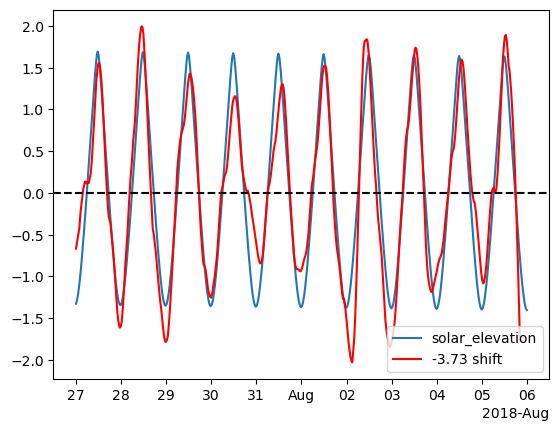

In [19]:
# Shift column B back by 3.5 hours
df_z_resampled['tree_der_shifted'] = df_z_resampled['tree_der'].shift(max_index)

fig, ax = plt.subplots()

ax.plot(df_z_resampled['solar_elevation'], label='solar_elevation')
ax.plot(df_z_resampled['tree_der_shifted'], c='r', label='-3.73 shift')
ax.axhline(0, c='black', ls='--')
ax.legend()
# ax.set_xlim(pd.Timestamp('2018-07-30'), pd.Timestamp('2018-08-01'))

locator = mdates.AutoDateLocator(minticks=7, maxticks=11)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# Dynamic Time Warping (DTW)

We can apply DTW to our data to find alignments between the time series.

In [20]:
from dtw import *

alignment = dtw(df_z_resampled['solar_elevation'], df_z_resampled['tree'], keep_internals=True)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



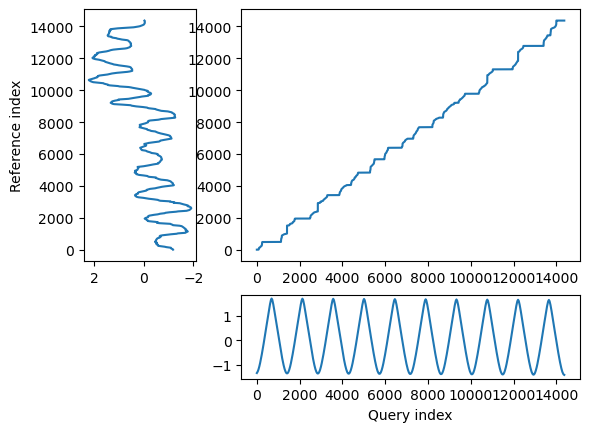

<AxesSubplot:>

In [21]:
alignment.plot('threeway')


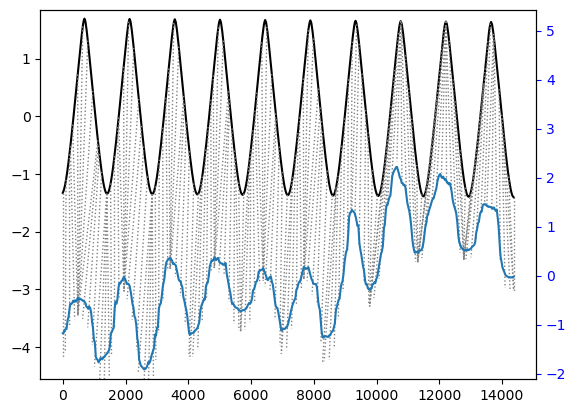

<AxesSubplot:>

In [22]:
## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
alignment.plot(type="twoway", offset=-3, match_indices=150)

As you can see it aligned the peaks pretty well. But in general, cross correlation was better for this kind of analysis.  

## Sound and DTW
Dynamic Time Warping (DTW) excels in aligning two time series that may vary in their rhythm or speed. This characteristic makes it particularly useful in applications such as speech recognition, where the goal is to identify specific words or phrases within audio recordings, despite variations in how different speakers might pronounce them. For instance, consider the task of recognizing the word "backpack" in various sound recordings. You might have a reference recording of someone clearly saying "backpack," which serves as your baseline. When you attempt to find occurrences of this word in recordings of other people speaking, you'll likely encounter variations in the rhythm — some may say it faster or slower than your reference, or even separate the words - "Back pack".  

DTW addresses this challenge by allowing a flexible, non-linear alignment between the time series. This flexibility enables DTW to effectively match sequences that have the same underlying patterns but are expressed over different time scales. Therefore, even if different speakers say "backpack" with varying speeds, DTW can align these variations with the reference, making it possible to accurately recognize the word across different speech rhythms.  

### "I like to eat Hummus"
Thats the sentence we will work with today. We have two recordings of me saying it. In every recording I say it a bit different. We will use DTW to align the words of the two recordings and even warp the every recording to sound like the other.  
Start by listening to these two files:
1. `hummus1.wav`
1. `hummus2.wav`

Sound files are basically time series data. So we can import them as np arrays.

In [23]:

from scipy.io import wavfile

samplerate, data1 = wavfile.read('hummus1.wav')

In [24]:
samplerate

48000

Sample rate is the number of samples per second. 48kHz is a standard sample rate for audio files.

In [25]:
data1.shape

(340992, 2)

Note that there are two channels, as the recording is stereo. We will work with only the first channel (left)

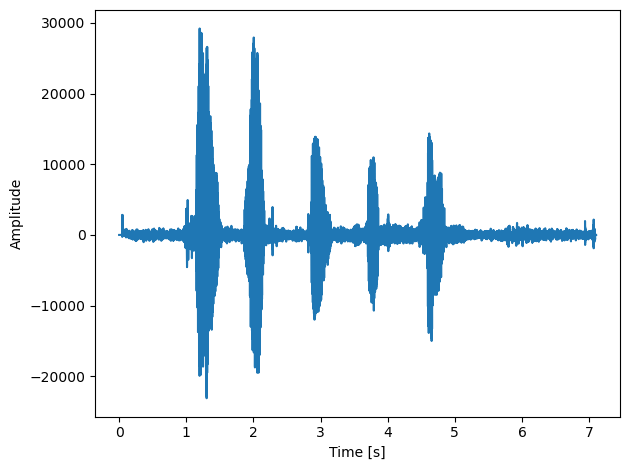

In [26]:
length = data1.shape[0] / samplerate
time = np.linspace(0., length, data1.shape[0])

fig, ax = plt.subplots()
ax.plot(time, data1[:, 0])
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")

plt.tight_layout()


Now lets import the second recording

In [27]:
samplerate, data2 = wavfile.read('hummus2.wav')

As you can see above these time series are huge, 7 seconds of data translate to 336,000 data points (and thats only one channel). In order to speed up computation time we will resample the data so make the series smaller. **Note, this wil drastically reduce the audio quality**

In [28]:
resample_factor = 64
hummus1 = data1[:, 0]
hummus2 = data2[:, 0]
hummus1_rs = signal.resample(hummus1, int(len(hummus1)/resample_factor))
hummus2_rs = signal.resample(hummus2, int(len(hummus2)/resample_factor))

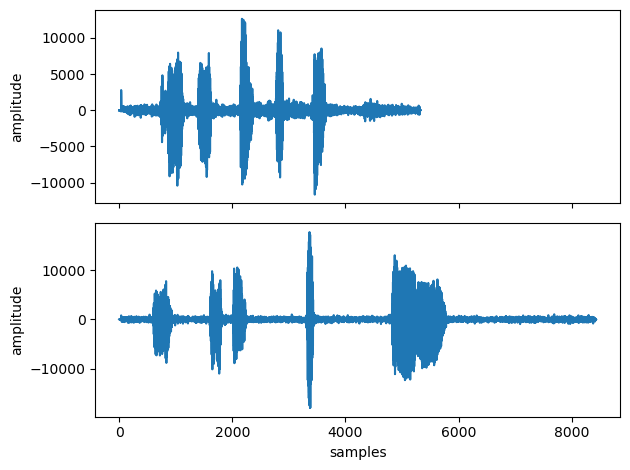

In [29]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(hummus1_rs)
ax[1].plot(hummus2_rs)

ax[1].set(xlabel='samples', ylabel='amplitude')
ax[0].set( ylabel='amplitude')

plt.tight_layout()


Implementation of DTW will be by using the dtw-python package.
Install dtw-python in anaconda using `conda install conda-forge::dtw-python`  
Documentation can be found [here](https://dynamictimewarping.github.io/py-api/html/)

In [30]:
from dtw import *

# aligning the two time series
alignment = dtw(hummus1_rs, hummus2_rs, keep_internals=True)

The package has built in functions for plotting the results. 

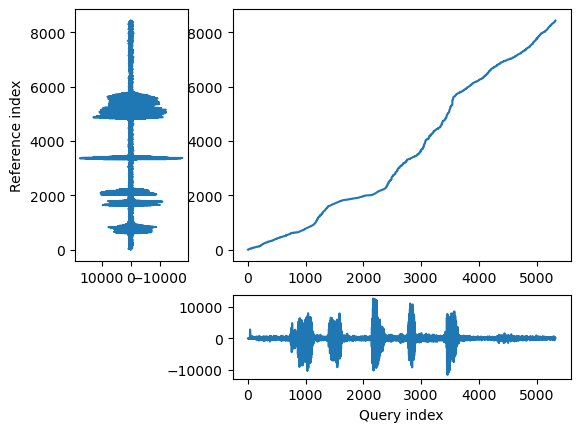

<AxesSubplot:>

In [31]:
alignment.plot('threeway')


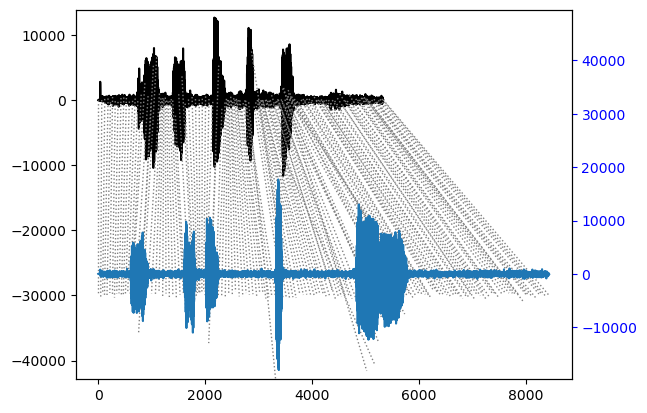

<AxesSubplot:>

In [32]:
## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
alignment.plot(type="twoway", offset=-30000, match_indices=150)

In the few cells below we warp each recording to match the rhythm of the other recording.  
first we get the warped index. If we are warping A to match the rhythm of B, then the `warped_index` will be an array in the length of B where each position has the matching index of A. 

In [33]:
hummus1_warped_index = warp(alignment,index_reference=False)
hummus2_warped_index = warp(alignment,index_reference=True)

In [34]:
hummus1_warped_index

array([   0,    0,    0, ..., 5325, 5326, 5327])

In [35]:
len(hummus1_warped_index)

8431

Below is a function for upsampling as we want to go back to the original sample rate so we can hear back the warped recording.

In [36]:
def upsampling(array, factor):
    # initialize the upsampled array with NaNs
    us = np.full(int(len(array) * factor), np.nan)
    # assign original array values to their new positions
    us[::factor] = array*factor
    # find indices of the NaNs and the non-NaNs (original values)
    nans = np.isnan(us)
    non_nans = ~nans
    # interpolate using np.interp
    # for x-coordinates, use np.arange(len(us)) for full array
    # for xp-coordinates (where we have actual values), use the non-NaN indices
    # for fp-coordinates (actual values to interpolate), use the non-NaN values in us
    us[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(non_nans), us[non_nans])
    return us.astype(int)

In [37]:
hummus1_warped_index_us = upsampling(hummus1_warped_index, resample_factor)
hummus2_warped_index_us = upsampling(hummus2_warped_index, resample_factor)

In [38]:
hummus1_warped_index_us.shape

(539584,)

Below, we replace the index values of `warped_index` with their corresponding amplitude values.

In [39]:
hummus1_warped = hummus1[hummus1_warped_index_us]
hummus2_warped = hummus2[hummus2_warped_index_us]


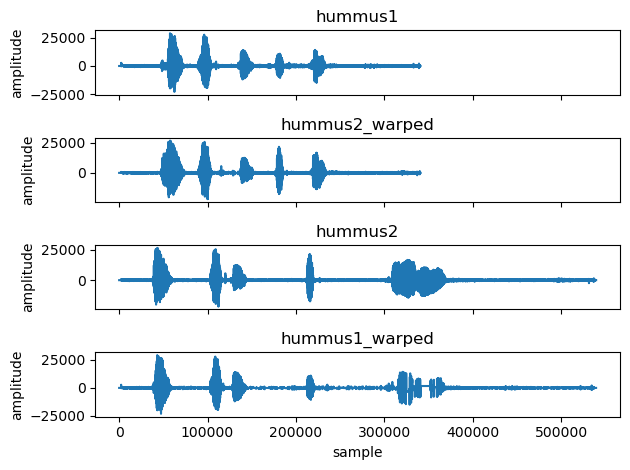

In [40]:
complet = [hummus1, hummus2_warped, hummus2, hummus1_warped]
labels = ['hummus1', 'hummus2_warped', 'hummus2', 'hummus1_warped']

fig, ax = plt.subplots(4,1, sharex=True)

for i, hummus in enumerate(complet):
    ax[i].plot(hummus)
    ax[i].set_title(labels[i])
    ax[i].set_ylabel('amplitude')
    print()

ax[3].set_xlabel('sample')

plt.tight_layout()


As you can see above the DTW algorithm did a great job.  
Now lets export it back to an audio file and listen. Don't forget that we downsampled and then upsampled so the quality will be bad, **but what matters now is the rhythm**.

In [41]:
from scipy.io.wavfile import write

write("hummus1_warped.wav", samplerate, hummus1_warped.astype(np.int16))
write("hummus2_warped.wav", samplerate, hummus2_warped.astype(np.int16))